## Quora Insincerity Detection
---
Author: kodooraKILLER <br>
Started: 03 Feb 2022

## Step Zero
#### Aim: Import necessary libraries, download objects and prepare constants (if any), Download data
---

In [5]:
!pip install nlpaug
!pip install pyspellchecker

In [6]:
# import all necessary libraries

# For dataframes
import pandas as pd 

# For numerical arrays
import numpy as np 

# For stemming/Lemmatisation/POS tagging
import spacy

# For getting stopwords
from spacy.lang.en.stop_words import STOP_WORDS

# For K-Fold cross validation
from sklearn.model_selection import KFold

# For visualizations
import matplotlib.pyplot as plt

#For generating random integers
import random

# For regular expressions
import re

# For handling string
import string

# For all torch-supported actions
import torch

# For Text augmentation
import nlpaug.augmenter.word as naw
from nlpaug import flow as naf

# For spell-check
from spellchecker import SpellChecker

# For performing mathematical operations
import math

# For dictionary related activites
from collections import defaultdict

# For counting actions (EDA)
from collections import  Counter

# For count vectorisation (EDA)
from sklearn.feature_extraction.text import CountVectorizer

# For one-hot encoding
from tensorflow.keras.utils import to_categorical

# For DL model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential

# For generating random integers
from random import randint

#For making wordclouds
from wordcloud import WordCloud 

# For TF-IDF vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

# For padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# For plotting
import seaborn as sns

print("Necessary libraries imported")

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
df.head(10)

## Step One
#### Aim: Time to do some EDA baby!
---
This phase involves complete understanding of what is there in the dataset, and the key nuances that needs to be understood before framing the Input-Output ML pipeline. 

EDA is performed separately at the [following notebook](https://www.kaggle.com/kodoorakiller/beginner-s-eda)

**So now what?** <br/>
By performing EDA, we learnt the following about our dataset:

- There are no null rows, and no duplicate rows
- Oh boy, We have hell-a-lot of data imbalance! (~93% of `target=0` and ~7% of `target=1`)
- There's bias, ie, we can see community specific and location specific terms skewed towards a category
- Both unigram and bigram analysis shows the abundance of Stop Words *(Spoiler alert: we're not doing anything to treat it😉)*
- We are unable to draw a clear relation between question length, average word length and target class *(they come in all shapes and sizes 🏈⚽)*
- We have a few HTML tags, and a few HTTP URLs
- We only have ©orporate emoticons™ in our dataset®
- The dataset is enriched with punctuations, keeping them could hopefully contribute to the knowledge mining process❕‼

## Step Two
#### Aim: Pre-Processing
---
Now that we have studied the dataset, its time for *cleaning* it. 

<br>
The following are done here: 

- Remove null rows and duplicate rows
- Remove columns that do not contribute to the decision making process (eg: `qid`)
- ~Remove stopwords~ 
- ~Remove punctuations and emojis~

<br>

**Why aren't you removing stopwords, punctuations and emojis?** <Br>
BERT is a contextual model that was trained on unprocessed data. Removing stopwords could have an effect as pointed in [this StackOverflow post](https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif). Emojis contribute to the sentiment (although our corpus only has business-class emojis like `©`, `™`, `®`); and the presence of punctuations could be handled by BERT as shown in [this StackOverflow post](https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif)

In [8]:
df=df.dropna()
df=df.drop_duplicates(subset="question_text")
df=df.drop(columns=['qid'])

#### Text Augmentation

As per the below shown figure, the imbalance between the two given classes is very very significant. If we train a model without handling this, we might run into a scenario where our model supports the majority class. To solve this, we can either downsample the majority class, or oversample the minority class.
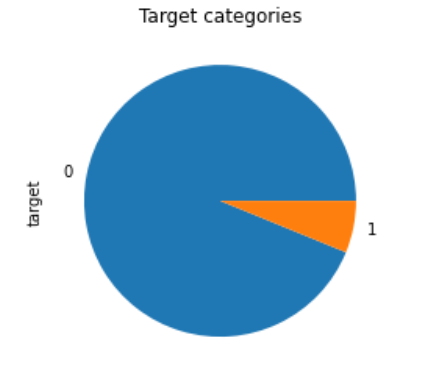

<br>
Here, we SMOTE the minority class, ie, produce synthetic lookalike copies of the elements present in the minority class so that we can restore balance of data classes.

`nlpaug` is a very useful text-augmentation library, more about it can be seen [here](https://www.analyticsvidhya.com/blog/2021/08/nlpaug-a-python-library-to-augment-your-text-data/). Basically, we do the following to generate/augment synthetic copies of `question_text` for minority class `target=1`:

1. Create 1 set of exact duplicates *(To ensure that we don't lose dataset quality to other augmenters)*
2. Perform back translation *(ie, convert an english sentence into french, and re-translate it back to english so that we could hit on the same sentence but with slight differences*
3. Perform word-level text augmentation *(ie, replace phrases of a sentence with its respective synonyms)*
4. Perform contextual text augmentation *(ie, generate lookalike copies using BERT)*

In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

french_aug = naw.BackTranslationAug(name="french_aug",from_model_name='Helsinki-NLP/opus-mt-en-fr', to_model_name='Helsinki-NLP/opus-mt-fr-en', device='cpu', batch_size=32, force_reload=False, verbose=0)
chinese_aug = naw.BackTranslationAug(name="chinese_aug",from_model_name='Helsinki-NLP/opus-mt-en-zh', to_model_name='Helsinki-NLP/opus-mt-zh-en', device='cpu', batch_size=32, force_reload=False, verbose=0)
german_aug= naw.BackTranslationAug(name="german_aug",from_model_name='Helsinki-NLP/opus-mt-en-de', to_model_name='Helsinki-NLP/opus-mt-de-en', device='cpu', batch_size=32, force_reload=False, verbose=0)
spanish_aug= naw.BackTranslationAug(name="spanish_aug",from_model_name='Helsinki-NLP/opus-mt-en-es', to_model_name='Helsinki-NLP/opus-mt-es-en', device='cpu', batch_size=32, force_reload=False, verbose=0)
arabic_aug= naw.BackTranslationAug(name="arabic_aug",from_model_name='Helsinki-NLP/opus-mt-en-ar', to_model_name='Helsinki-NLP/opus-mt-ar-en', device='cpu', batch_size=32, force_reload=False, verbose=0)
hindi_aug= naw.BackTranslationAug(name="german_aug",from_model_name='Helsinki-NLP/opus-mt-en-hi', to_model_name='Helsinki-NLP/opus-mt-hi-en', device='cpu', batch_size=32, force_reload=False, verbose=0)

synonym_aug = naw.SynonymAug(aug_src='wordnet', model_path=None, name='synonym_aug', aug_min=1, aug_max=10, aug_p=0.2, lang='eng', stopwords=STOP_WORDS, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None, force_reload=False, verbose=0)
bert_subs_aug = naw.ContextualWordEmbsAug(model_path='distilbert-base-cased', name="bert_subs_aug",action="substitute", top_k=5)
bert_ins_aug = naw.ContextualWordEmbsAug(model_path='distilbert-base-cased', name="bert_ins_aug",action="insert", top_k=5)

print("Induvidual augmenters downloaded")

def rand_qn():
    curdf=df[df.target==1].question_text.reset_index()
    index=random.randint(0, len(curdf))
    return curdf.loc[index,"question_text"]

text=rand_qn()

print("Original sentence: \t", text)
print("\nAugmented results:")
print("EN->FRench->EN translator: \t",french_aug.augment(text))
print("EN->ZHinese->EN translator: \t",chinese_aug.augment(text))
print("EN->DErman->EN translator: \t",german_aug.augment(text))
print("EN->ESpanish->EN translator: \t",spanish_aug.augment(text))
print("EN->ARabic->EN translator: \t",arabic_aug.augment(text))
print("EN->HIndi->EN translator: \t",hindi_aug.augment(text))
print("Synonym augmenter: \t",synonym_aug.augment(text))
print("BERT phrase substituter: \t",bert_subs_aug.augment(text))
print("BERT phrase inserter: \t",bert_ins_aug.augment(text))

**We are going to augment the dataset in such a way that there is equal number of `target=0` and `target=1` classes, irrespective of the noise we create by augmentation** 
<br>
We equalise 93:7 ratio to 50:50 ratio by generating **15 augmented sets** of the minority class, wherein
- 2 sets of exact duplicates
- 1 set from EN-FR-EN
- 1 set from EN-ZH-EN
- 1 set from EN-DE-EN
- 1 set from EN-ES-EN
- 1 set from EN-AR-EN
- 1 set from EN-HI-EN
- 2 sets from Synonym-augmenter
- 3 sets from BERT-Substituter
- 2 sets from BERT-Inserter
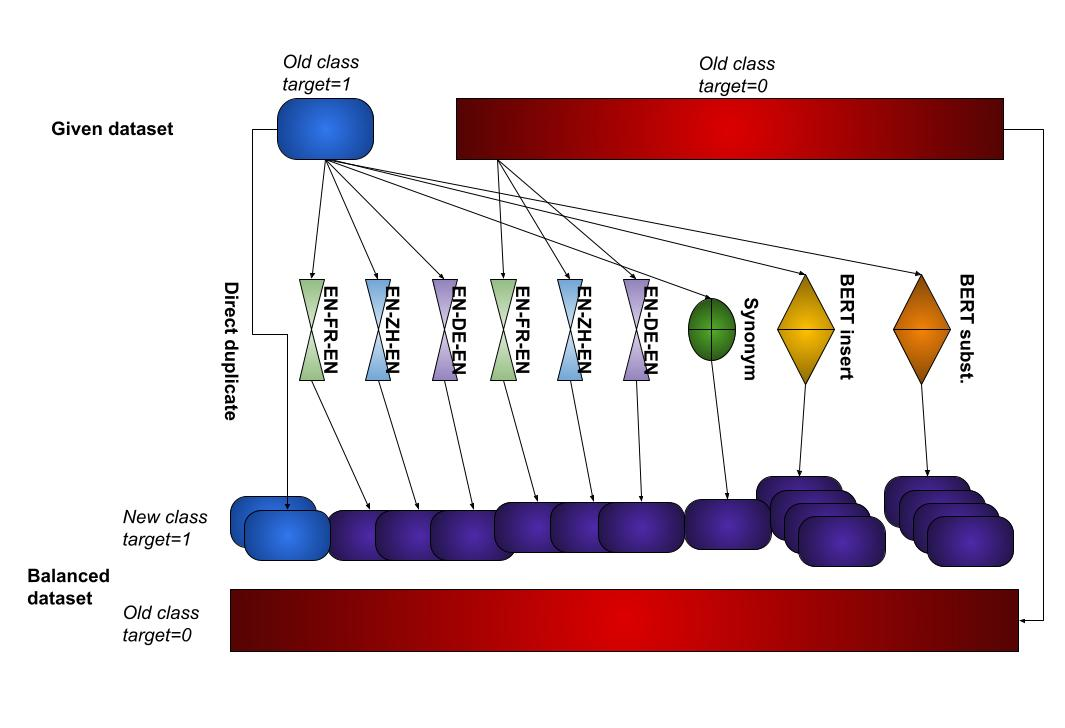

In [34]:
def restore_balance(df):
    allzero=df[df.target==0]
    allone=df[df.target==1]
    sentences=allone.question_text.tolist()
    
    duplicate_set=sentences*2
    frset=french_aug.augment(sentences)
    arset=arabic_aug.augment(sentences)
    hiset=hindi_aug.augment(sentences)
    deset=german_aug.augment(sentences)
    esset=spanish_aug.augment(sentences)
    zhset=chinese_aug.augment(sentences)
    synset=synonym_aug.augment(sentences,n=2)
    bert_subs_set=bert_subs_aug.augment(sentences,n=3)
    bert_ins_set=bert_ins_aug.augment(sentences,n=2)
    
    all_augmentations=duplicate_set+frset+arset+hiset+deset+esset+zhset+synset+bert_subs_set+bert_ins_set
    allone_new=pd.DataFrame({
                                "question_text": all_augmentations,
                                "target":np.ones(len(all_augmentations),dtype=type(df.loc[0,"target"]))
                            })
    
    return pd.concat([allzero,allone_new])

aug_df=restore_balance(df.loc[:100])

In [36]:
aug_df.tail(10)

In [41]:
sentarr=df[df.target==1].question_text.tolist()
frset=list()
for i in range(len(df[df.target==1])//10):
    print("set: ",i*10,(i+1)*10)
    frset+=french_aug.augment(sentarr[i*10:(i+1)*10])

In [25]:
df.loc[1215721,"question_text"]

In [20]:
len("To you, does being a Christian mean\xa0 inviting in the spirit of Jesus into you and suppressing our own spirit? 'Thy will not mine' and all that? Do you like living as a zombie of someone else's spirit - however perfect it may be? Don't you want to experience and improve your own will and spirit and live your life as you, not Jesus?".split())

## Step Three
#### Aim: Feature Engineering
---
Once we have cleaned our dataset, our next set of steps should be more oriented towards the model development pipeline. Since we're going for a BERT-istic approach, we'll have to feature-engineer our dataset *(ie, convert our dataset so that it could be properly understood and utilised as a means of learning during model training)*

<br>

The following are done in this phase
- Tokenise `question_text` sentences
- Convert to a BERT-acceptable entity
- Handle dataset imbalance
- Train-test split


In [ ]:
df[df.target==1].head(10)

In [ ]:

text="If both Honey Singh and Justin Bieber fall from the 5th floor, who will survive?"
for _ in range(10):
    print(aug.augment(text))

In [ ]:
aug_w2v = naw.WordEmbsAug(
    model_type='glove', model_path='../input/glove6b300dtxt/glove.6B.300d.txt',
    action="substitute")
print("Original:")
print(test_sentence)